* **What is the Hot Hand Phenomenon:**
    * The idea that basketball players can find themselves with a ‘hot hand’ – a streak in which they seem magically to make shot after shot. 

# Table of Contents

* [Data Preparation](#Data-Preparation)
* [Testing Hothands using Conditional Probability](#Conditional-Probability)
* [Testing Hothands using Auto Correlation](#Auto-Correlation)
* [Testing Hothands using Regression Analysis](#Regression-Analysis)

In [1]:
import numpy as np
import pandas as pd

shotlog = pd.read_csv("datasets/Shotlog_16_17.csv")
shotlog.head()

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,time,date,shoot_player,time_from_last_shot,quarter,current_shot_outcome
0,NaN,SF,Yes,97.0,SCORED,ATL,Pullup Jump Shot,2,WAS,405.0,1:09,10/27/2016,Kent Bazemore,NaN,1,MISSED
1,MISSED,C,Yes,52.0,SCORED,ATL,Tip Dunk Shot,2,WAS,250.0,1:11,10/27/2016,Dwight Howard,2.0,1,SCORED
2,SCORED,SG,Yes,239.0,MISSED,ATL,Jump Shot,2,WAS,223.0,1:41,10/27/2016,Kyle Korver,30.0,1,SCORED
3,SCORED,PG,Yes,102.0,SCORED,ATL,Pullup Jump Shot,2,WAS,385.0,2:16,10/27/2016,Dennis Schroder,35.0,1,SCORED
4,SCORED,PF,Yes,128.0,MISSED,ATL,Turnaround Jump Shot,2,WAS,265.0,2:40,10/27/2016,Paul Millsap,24.0,1,MISSED


In [2]:
shotlog.shape

(210072, 16)

## Data Preparation

In [3]:
shotlog.info()
"""we have missing values in team_previous_shot, location_x, location_y, opponent_previous_shot"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210072 entries, 0 to 210071
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   team_previous_shot      207612 non-null  object 
 1   player_position         210072 non-null  object 
 2   home_game               210072 non-null  object 
 3   location_x              209675 non-null  float64
 4   opponent_previous_shot  208462 non-null  object 
 5   home_team               210072 non-null  object 
 6   shot_type               210072 non-null  object 
 7   points                  210072 non-null  int64  
 8   away_team               210072 non-null  object 
 9   location_y              209675 non-null  float64
 10  time                    210072 non-null  object 
 11  date                    210072 non-null  object 
 12  shoot_player            210072 non-null  object 
 13  time_from_last_shot     200072 non-null  float64
 14  quarter             

'we have missing values in team_previous_shot, location_x, location_y, opponent_previous_shot'

**Current_shot_outcome is stored as: MISSED OR SCORED --> convert to a numerical variable**

In [4]:
shotlog['current_shot_hit'] = np.where(shotlog['current_shot_outcome'] == "SCORED", 1, 0)
shotlog.head()

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,time,date,shoot_player,time_from_last_shot,quarter,current_shot_outcome,current_shot_hit
0,NaN,SF,Yes,97.0,SCORED,ATL,Pullup Jump Shot,2,WAS,405.0,1:09,10/27/2016,Kent Bazemore,NaN,1,MISSED,0
1,MISSED,C,Yes,52.0,SCORED,ATL,Tip Dunk Shot,2,WAS,250.0,1:11,10/27/2016,Dwight Howard,2.0,1,SCORED,1
2,SCORED,SG,Yes,239.0,MISSED,ATL,Jump Shot,2,WAS,223.0,1:41,10/27/2016,Kyle Korver,30.0,1,SCORED,1
3,SCORED,PG,Yes,102.0,SCORED,ATL,Pullup Jump Shot,2,WAS,385.0,2:16,10/27/2016,Dennis Schroder,35.0,1,SCORED,1
4,SCORED,PF,Yes,128.0,MISSED,ATL,Turnaround Jump Shot,2,WAS,265.0,2:40,10/27/2016,Paul Millsap,24.0,1,MISSED,0


**Ensure "date" variable is stored as data type**

In [5]:
import datetime as dt
shotlog['date'] = pd.to_datetime(shotlog['date'])

**Ensure "time" variable is stored as datetime**
* Add 00 to the time variable, since the datetime variable is stored as HH:MM:SS
* Work with to_timedelta to work with variable with only time information

In [6]:
shotlog['time'] = pd.to_timedelta('00:' + shotlog['time'])
shotlog['time'].describe()

count                       210072
mean     0 days 00:06:08.994773220
std      0 days 00:03:28.346263848
min                0 days 00:00:00
25%                0 days 00:03:08
50%                0 days 00:06:06
75%                0 days 00:09:10
max                0 days 00:12:00
Name: time, dtype: object

### The dataset currently only has information on ALL shots taken in the game. We don't have any variable to that tells if the previous shot by the same player, in the same game, was a score or miss.

* Create a lagged variable, to indicate the result of the previous shot by the same player, in the same game
    * Sort the shot outcome by the time in the game
    * Group the data by player, and game (date) and use the shift() operator to create a lag variable

In [7]:
shotlog['lag_shot_hit'] = shotlog.sort_values(by='time', ascending = True).groupby(['shoot_player','date'])['current_shot_hit'].shift(1)
shotlog

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,time,date,shoot_player,time_from_last_shot,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit
0,NaN,SF,Yes,97.0,SCORED,ATL,Pullup Jump Shot,2,WAS,405.0,0 days 00:01:09,2016-10-27,Kent Bazemore,NaN,1,MISSED,0,0.0
1,MISSED,C,Yes,52.0,SCORED,ATL,Tip Dunk Shot,2,WAS,250.0,0 days 00:01:11,2016-10-27,Dwight Howard,2.0,1,SCORED,1,NaN
2,SCORED,SG,Yes,239.0,MISSED,ATL,Jump Shot,2,WAS,223.0,0 days 00:01:41,2016-10-27,Kyle Korver,30.0,1,SCORED,1,0.0
3,SCORED,PG,Yes,102.0,SCORED,ATL,Pullup Jump Shot,2,WAS,385.0,0 days 00:02:16,2016-10-27,Dennis Schroder,35.0,1,SCORED,1,1.0
4,SCORED,PF,Yes,128.0,MISSED,ATL,Turnaround Jump Shot,2,WAS,265.0,0 days 00:02:40,2016-10-27,Paul Millsap,24.0,1,MISSED,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210067,SCORED,F,No,58.0,MISSED,MIA,Jump Shot,2,WAS,153.0,0 days 00:08:18,2017-04-12,Daniel Ochefu,39.0,4,SCORED,1,1.0
210068,SCORED,F,No,52.0,SCORED,MIA,Dunk,2,WAS,250.0,0 days 00:08:51,2017-04-12,Daniel Ochefu,33.0,4,SCORED,1,1.0
210069,SCORED,F,No,171.0,SCORED,MIA,Jump Shot,2,WAS,149.0,0 days 00:09:20,2017-04-12,Daniel Ochefu,29.0,4,MISSED,0,1.0
210070,MISSED,PF,No,285.0,SCORED,MIA,Jump Shot,3,WAS,334.0,0 days 00:10:33,2017-04-12,Chris McCullough,73.0,4,MISSED,0,NaN


In [8]:
shotlog.sort_values(by = ["shoot_player", "date", "time"], ascending = [True, True, True])

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,time,date,shoot_player,time_from_last_shot,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit
42660,MISSED,C,No,210.0,SCORED,GSW,Jump Shot,2,DAL,269.0,0 days 00:07:23,2016-11-09,A.J. Hammons,43.0,4,SCORED,1,NaN
42661,SCORED,C,No,308.0,SCORED,GSW,Jump Shot,3,DAL,202.0,0 days 00:07:56,2016-11-09,A.J. Hammons,33.0,4,SCORED,1,1.0
42664,MISSED,C,No,167.0,SCORED,GSW,Jump Shot,2,DAL,318.0,0 days 00:09:26,2016-11-09,A.J. Hammons,51.0,4,MISSED,0,1.0
42667,SCORED,C,No,131.0,MISSED,GSW,Jump Shot,2,DAL,337.0,0 days 00:11:46,2016-11-09,A.J. Hammons,62.0,4,MISSED,0,0.0
42668,MISSED,C,No,72.0,MISSED,GSW,Tip Layup Shot,2,DAL,248.0,0 days 00:11:47,2016-11-09,A.J. Hammons,1.0,4,SCORED,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70255,BLOCKED,C,Yes,866.0,SCORED,GSW,Layup,2,UTA,252.0,0 days 00:10:33,2017-04-10,Zaza Pachulia,5.0,4,MISSED,0,0.0
70218,SCORED,C,Yes,58.0,MISSED,GSW,Layup,2,UTA,241.0,0 days 00:11:08,2017-04-10,Zaza Pachulia,47.0,2,SCORED,1,0.0
70264,SCORED,C,Yes,239.0,SCORED,GSW,Jump Shot,2,LAL,272.0,0 days 00:01:41,2017-04-12,Zaza Pachulia,29.0,1,SCORED,1,NaN
70270,MISSED,C,Yes,52.0,SCORED,GSW,Tip Layup Shot,2,LAL,251.0,0 days 00:04:32,2017-04-12,Zaza Pachulia,1.0,1,SCORED,1,1.0


### Create a dataframe that stores the average shooting accuracies of the players over the season

In [9]:
player_stats = shotlog.groupby(["shoot_player"])["current_shot_hit"].mean()
player_stats = player_stats.reset_index()
player_stats.head()

,shoot_player,current_shot_hit
0,A.J. Hammons,0.404762
1,Aaron Brooks,0.403333
2,Aaron Gordon,0.454861
3,Aaron Harrison,0.000000
4,Adreian Payne,0.425926


In [10]:
player_stats.rename(columns = {'current_shot_hit':'average_hit'}, inplace = True)

In [11]:
"""Merge player_stats dataframe with the shot_log dataframe"""
shotlog = pd.merge(shotlog, player_stats, on = "shoot_player")
shotlog.head()

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,time,date,shoot_player,time_from_last_shot,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit,average_hit
0,NaN,SF,Yes,97.0,SCORED,ATL,Pullup Jump Shot,2,WAS,405.0,0 days 00:01:09,2016-10-27,Kent Bazemore,NaN,1,MISSED,0,0.0,0.408587
1,MISSED,SF,Yes,279.0,SCORED,ATL,Jump Shot,3,WAS,130.0,0 days 00:03:11,2016-10-27,Kent Bazemore,4.0,1,MISSED,0,0.0,0.408587
2,MISSED,SF,Yes,58.0,SCORED,ATL,Cutting Layup Shot,2,WAS,275.0,0 days 00:09:53,2016-10-27,Kent Bazemore,30.0,2,MISSED,0,0.0,0.408587
3,SCORED,SF,Yes,868.0,SCORED,ATL,Jump Shot,3,WAS,475.0,0 days 00:01:02,2016-10-27,Kent Bazemore,47.0,3,MISSED,0,NaN,0.408587
4,SCORED,SF,Yes,691.0,MISSED,ATL,Pullup Jump Shot,3,WAS,100.0,0 days 00:04:50,2016-10-27,Kent Bazemore,39.0,3,SCORED,1,0.0,0.408587


### Create a dataframe to indicate how many shots are recorded for each player

In [12]:
player_shots = shotlog.groupby(["shoot_player"]).size().reset_index(name = 'shot_count')
player_shots.sort_values(by = 'shot_count', ascending = False).head()

,shoot_player,shot_count
402,Russell Westbrook,1940
25,Andrew Wiggins,1568
106,DeMar DeRozan,1545
193,James Harden,1532
28,Anthony Davis,1525


### Create a dataframe to indicate how many shots are recorded for each player. This is needed because you can't compare a player who took 2 shots in a game, which someone who took 30 shots in a game

In [13]:
player_game = shotlog.groupby(["shoot_player","date"]).size().reset_index(name = "shot_per_game")
player_game.head()

,shoot_player,date,shot_per_game
0,A.J. Hammons,2016-11-09,5
1,A.J. Hammons,2016-11-23,1
2,A.J. Hammons,2016-11-25,1
3,A.J. Hammons,2016-12-03,2
4,A.J. Hammons,2016-12-07,2


**Merge the total shots per player and shots per player per game dataframes with the original shot log dataframe**

In [14]:
shotlog = pd.merge(shotlog, player_shots, on = "shoot_player")
shotlog = pd.merge(shotlog, player_game, on = ["shoot_player","date"])
display(shotlog)

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,...,date,shoot_player,time_from_last_shot,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit,average_hit,shot_count,shot_per_game
0,NaN,SF,Yes,97.0,SCORED,ATL,Pullup Jump Shot,2,WAS,405.0,...,2016-10-27,Kent Bazemore,NaN,1,MISSED,0,0.0,0.408587,722,7
1,MISSED,SF,Yes,279.0,SCORED,ATL,Jump Shot,3,WAS,130.0,...,2016-10-27,Kent Bazemore,4.0,1,MISSED,0,0.0,0.408587,722,7
2,MISSED,SF,Yes,58.0,SCORED,ATL,Cutting Layup Shot,2,WAS,275.0,...,2016-10-27,Kent Bazemore,30.0,2,MISSED,0,0.0,0.408587,722,7
3,SCORED,SF,Yes,868.0,SCORED,ATL,Jump Shot,3,WAS,475.0,...,2016-10-27,Kent Bazemore,47.0,3,MISSED,0,NaN,0.408587,722,7
4,SCORED,SF,Yes,691.0,MISSED,ATL,Pullup Jump Shot,3,WAS,100.0,...,2016-10-27,Kent Bazemore,39.0,3,SCORED,1,0.0,0.408587,722,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210067,SCORED,C,No,878.0,MISSED,DET,Layup,2,WAS,250.0,...,2017-04-10,Ian Mahinmi,21.0,1,MISSED,0,1.0,0.590909,110,5
210068,SCORED,C,No,878.0,MISSED,DET,Driving Layup,2,WAS,250.0,...,2017-04-10,Ian Mahinmi,31.0,1,SCORED,1,0.0,0.590909,110,5
210069,MISSED,C,No,863.0,SCORED,DET,Hook Shot,2,WAS,303.0,...,2017-04-10,Ian Mahinmi,78.0,2,MISSED,0,NaN,0.590909,110,5
210070,SCORED,C,No,58.0,SCORED,DET,Layup,2,WAS,264.0,...,2017-04-10,Ian Mahinmi,43.0,3,SCORED,1,1.0,0.590909,110,5


In [15]:
shotlog.sort_values(by = ["shoot_player", "date", "time"], ascending = [True, True, True])

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,...,date,shoot_player,time_from_last_shot,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit,average_hit,shot_count,shot_per_game
50484,MISSED,C,No,210.0,SCORED,GSW,Jump Shot,2,DAL,269.0,...,2016-11-09,A.J. Hammons,43.0,4,SCORED,1,NaN,0.404762,42,5
50485,SCORED,C,No,308.0,SCORED,GSW,Jump Shot,3,DAL,202.0,...,2016-11-09,A.J. Hammons,33.0,4,SCORED,1,1.0,0.404762,42,5
50486,MISSED,C,No,167.0,SCORED,GSW,Jump Shot,2,DAL,318.0,...,2016-11-09,A.J. Hammons,51.0,4,MISSED,0,1.0,0.404762,42,5
50487,SCORED,C,No,131.0,MISSED,GSW,Jump Shot,2,DAL,337.0,...,2016-11-09,A.J. Hammons,62.0,4,MISSED,0,0.0,0.404762,42,5
50488,MISSED,C,No,72.0,MISSED,GSW,Tip Layup Shot,2,DAL,248.0,...,2016-11-09,A.J. Hammons,1.0,4,SCORED,1,0.0,0.404762,42,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72782,BLOCKED,C,Yes,866.0,SCORED,GSW,Layup,2,UTA,252.0,...,2017-04-10,Zaza Pachulia,5.0,4,MISSED,0,0.0,0.535948,306,5
72781,SCORED,C,Yes,58.0,MISSED,GSW,Layup,2,UTA,241.0,...,2017-04-10,Zaza Pachulia,47.0,2,SCORED,1,0.0,0.535948,306,5
72783,SCORED,C,Yes,239.0,SCORED,GSW,Jump Shot,2,LAL,272.0,...,2017-04-12,Zaza Pachulia,29.0,1,SCORED,1,NaN,0.535948,306,3
72784,MISSED,C,Yes,52.0,SCORED,GSW,Tip Layup Shot,2,LAL,251.0,...,2017-04-12,Zaza Pachulia,1.0,1,SCORED,1,1.0,0.535948,306,3


**Points and quarter variables are stored as integer. We will change to objects for our study**

In [16]:
shotlog["points"] = shotlog["points"].astype(object)
shotlog["quarter"] = shotlog["quarter"].astype(object)

**Drop rows with a missing values in lagged variables**
    * Since our study is based on studying how outcome of previous shot affects the outcome of the current shot

In [17]:
shotlog = shotlog[pd.notnull(shotlog["lag_shot_hit"])]

In [18]:
shotlog.shape

(185052, 21)

## Conditional-Probability

* With hothand, we are trying to prove that the probability of a shot going in, is higher after a previous shot that has already gone in, as opposed to a previous shot that has missed


* **P(A|B) = P(A intersection B) / P(B)**
    * P(A|B) = prob. of event A happening, if event B happens
    * P(A intersection B) = prob. of both event A and event B happening
    
    
* **If event A & event B are independant of each other: P(A|B) = P(A) and P(B|A) = P(B)**


* In our case:
    * A = prob. of making consecutive shots
    * B = prob. of making previous shot

In [19]:
"""First we need variable that indicates making consecutive shots"""
shotlog["conse_shot_hit"] = np.where((shotlog["current_shot_hit"] == 1) & (shotlog["lag_shot_hit"] ==1), 1, 0)
shotlog.head()

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,...,shoot_player,time_from_last_shot,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit,average_hit,shot_count,shot_per_game,conse_shot_hit
0,NaN,SF,Yes,97.0,SCORED,ATL,Pullup Jump Shot,2,WAS,405.0,...,Kent Bazemore,NaN,1,MISSED,0,0.0,0.408587,722,7,0
1,MISSED,SF,Yes,279.0,SCORED,ATL,Jump Shot,3,WAS,130.0,...,Kent Bazemore,4.0,1,MISSED,0,0.0,0.408587,722,7,0
2,MISSED,SF,Yes,58.0,SCORED,ATL,Cutting Layup Shot,2,WAS,275.0,...,Kent Bazemore,30.0,2,MISSED,0,0.0,0.408587,722,7,0
4,SCORED,SF,Yes,691.0,MISSED,ATL,Pullup Jump Shot,3,WAS,100.0,...,Kent Bazemore,39.0,3,SCORED,1,0.0,0.408587,722,7,0
5,MISSED,SF,Yes,691.0,MISSED,ATL,Pullup Jump Shot,2,WAS,181.0,...,Kent Bazemore,20.0,3,MISSED,0,1.0,0.408587,722,7,0


* We than create a player level dataframe, that calcuates: 
    * avg. of conse_shot_hit for each player - joint prob. of making current and previous shot - P(A intersection B)
    * avg. of lag_shot_hit - prob. of making previous shot - P(B)

In [20]:
player_prob = shotlog.groupby(["shoot_player"])["conse_shot_hit", "lag_shot_hit"].mean()
player_prob = player_prob.reset_index()
player_prob.rename(columns = {"lag_shot_hit": "average_lag_hit"}, inplace = True)
player_prob.head()

<ipython-input-20-07a343278e35>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  player_prob = shotlog.groupby(["shoot_player"])["conse_shot_hit", "lag_shot_hit"].mean()


,shoot_player,conse_shot_hit,average_lag_hit
0,A.J. Hammons,0.185185,0.407407
1,Aaron Brooks,0.180672,0.415966
2,Aaron Gordon,0.213010,0.457908
3,Adreian Payne,0.153846,0.410256
4,Al Horford,0.215553,0.470668


**Calculate conditional probability for each player**

In [21]:
player_prob["conditional_prob"] = player_prob["conse_shot_hit"]/player_prob["average_lag_hit"]
player_prob.head()

,shoot_player,conse_shot_hit,average_lag_hit,conditional_prob
0,A.J. Hammons,0.185185,0.407407,0.454545
1,Aaron Brooks,0.180672,0.415966,0.434343
2,Aaron Gordon,0.213010,0.457908,0.465181
3,Adreian Payne,0.153846,0.410256,0.375000
4,Al Horford,0.215553,0.470668,0.457971


In [22]:
"Merge player_prob with player_stat data frame"
player_stats = pd.merge(player_prob, player_stats, on = "shoot_player")
player_stats.head(10)

,shoot_player,conse_shot_hit,average_lag_hit,conditional_prob,average_hit
0,A.J. Hammons,0.185185,0.407407,0.454545,0.404762
1,Aaron Brooks,0.180672,0.415966,0.434343,0.403333
2,Aaron Gordon,0.213010,0.457908,0.465181,0.454861
3,Adreian Payne,0.153846,0.410256,0.375000,0.425926
4,Al Horford,0.215553,0.470668,0.457971,0.473159
5,Al Jefferson,0.216749,0.507389,0.427184,0.498938
6,Al-Farouq Aminu,0.160494,0.390123,0.411392,0.392704
7,Alan Anderson,0.115385,0.384615,0.300000,0.375000
8,Alan Williams,0.280000,0.524444,0.533898,0.516854
9,Alec Burks,0.159420,0.415459,0.383721,0.399194


In [23]:
player_stats.info()

"""We have data for 481 players, but conditional_probablity of only 473 players! This is because some players might not
have taken consecutive shots in any game. We will delete the observations for these players"""

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 0 to 480
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   shoot_player      481 non-null    object 
 1   conse_shot_hit    481 non-null    float64
 2   average_lag_hit   481 non-null    float64
 3   conditional_prob  473 non-null    float64
 4   average_hit       481 non-null    float64
dtypes: float64(4), object(1)
memory usage: 22.5+ KB


'We have data for 481 players, but conditional_probablity of only 473 players! This is because some players might not\nhave taken consecutive shots in any game. We will delete the observations for these players'

In [24]:
player_stats = player_stats[pd.notnull(player_stats["conditional_prob"])]

### Compare conditional probability for consecutive shots vs. normal probability of player scoring
* P(A|B) for a player = probability of consecutive shots =  conditional_prob
* Probability of scoring a shot = unconditional probability = average_hit


* If our result shows that probability of scoring current shot (average_hit) and probability of scoring consecutive shots (conditional_prob) are same, then hot hands doesn't exist

In [25]:
player_stats.sort_values(by = "conditional_prob", ascending = False).head(10)

,shoot_player,conse_shot_hit,average_lag_hit,conditional_prob,average_hit
36,Axel Toupane,0.500000,0.666667,0.750000,0.555556
293,Lucas Nogueira,0.504505,0.675676,0.746667,0.660256
402,Salah Mejri,0.451220,0.621951,0.725490,0.642336
74,Chris McCullough,0.388889,0.555556,0.700000,0.500000
102,DeAndre Jordan,0.489919,0.703629,0.696275,0.714038
121,Deyonta Davis,0.360000,0.520000,0.692308,0.510638
338,Montrezl Harrell,0.435986,0.643599,0.677419,0.652174
182,JaVale McGee,0.437247,0.651822,0.670807,0.652038
468,Walter Tavares,0.666667,1.000000,0.666667,0.800000
343,Nick Collison,0.428571,0.642857,0.666667,0.608696


**To test hot hand, compare 'conditional_prob' with 'average_hit'**

In [26]:
player_stats["diff_prob"] = player_stats["conditional_prob"] - player_stats["average_hit"]
player_stats = pd.merge(player_stats, player_shots, on = "shoot_player")
display(player_stats.sort_values(by = "diff_prob", ascending = False).head(10))

"""We can see that Lamar Patternson has 30% difference b/w conditional_prob and average_hit. But is sample size is very 
small (15 shots). Damjan Rudez and Miles Plumlee have we have around 90 observations and around 17% difference"""

,shoot_player,conse_shot_hit,average_lag_hit,conditional_prob,average_hit,diff_prob,shot_count
277,Lamar Patterson,0.090909,0.181818,0.500000,0.200000,0.300000,15
120,Diamond Stone,0.125000,0.250000,0.500000,0.230769,0.269231,13
274,Kyle Wiltjer,0.166667,0.333333,0.500000,0.285714,0.214286,14
301,Marcus Georges-Hunt,0.250000,0.500000,0.500000,0.285714,0.214286,7
72,Chris McCullough,0.388889,0.555556,0.700000,0.500000,0.200000,32
35,Axel Toupane,0.500000,0.666667,0.750000,0.555556,0.194444,9
119,Deyonta Davis,0.360000,0.520000,0.692308,0.510638,0.181669,47
323,Mike Miller,0.307692,0.538462,0.571429,0.391304,0.180124,23
86,Damjan Rudez,0.211538,0.403846,0.523810,0.352273,0.171537,88
327,Miles Plumlee,0.285714,0.446429,0.640000,0.478261,0.161739,92


'We can see that Lamar Patternson has 30% difference b/w conditional_prob and average_hit. But is sample size is very \nsmall (15 shots). Damjan Rudez and Miles Plumlee have we have around 90 observations and around 17% difference'

### We need a T-test to test if the player's average probability of scoring is statistically significantly different than their conditional probability.

* We need to choose a significance level:
    * if test produces p value < chosen significance level --> there is a statistically significant difference between the 2 probablities
    * if p value > chosen significant level --> we fail to find evidence that the 2 probabilities are statistically significantly difference
    * common significance value = 0.05

In [27]:
import scipy.stats as sp

In [28]:
"""Use the ttest_ind() function to calculate the test statistics"""
sp.stats.ttest_ind(player_stats["conditional_prob"], player_stats["average_hit"])

Ttest_indResult(statistic=-1.441605145484725, pvalue=0.14974543830243517)

* statistic: t - statistics
* pvalue


* **p value for the test is about 0.14 (> 0.05) --> Thus the conditional probability is not statistically significantly different than the average success rate. --> WE FAIL TO FIND EVIDENCE TO SUPPORT "HOT HAND"**

## Auto Correlation

* Another way to test hot hand

* Linear Relationship b/w adjacent values of the same variable:
    * relationship b/w performance this year and performance last year
    * relationship b/w scoring current goal and scoring in previous attempt 

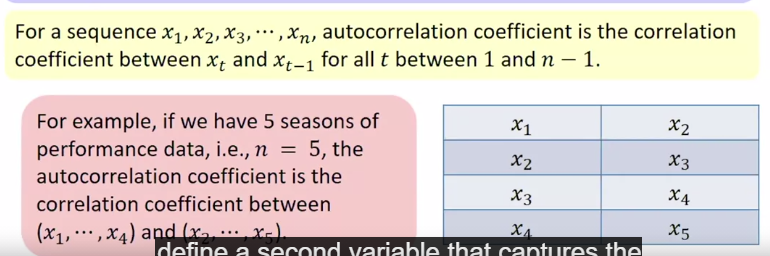


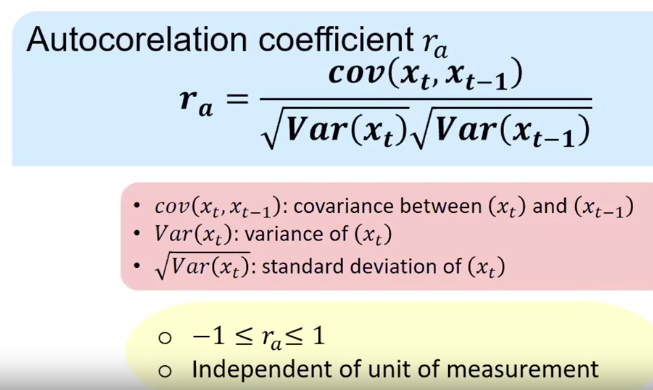


### Intepreting Autocorrelation:
* **autocorrelation value > 0:**
    * positive autocorrelation
    * if previous performance is above average --> current performance will also be above average
    * if previous performance is below average --> current performance will also be below average
    * smooth line in graph
    

* **autocorrelation value < 0:**
    * negative autocorrelation
    * if previous performance is above average --> current performance will be below average
    * if previous performance is below average --> current performance will be above average
    * zigzag line in graph

* We can calcualte the autocorrelation coefficient by calculating the correlation coefficient between the "current_shot_hit" and the "lag_shot_hit"

* Python also provides a autocorr(lag = 1) function to calculate the first order autocorrelation coefficient! However, if we directly use this function, we will be treating the last shot of the previous game, and the first shot of the current game as a pair as well! We don't want this! We need game wise values!

In [29]:
display(shotlog["current_shot_hit"].corr(shotlog["lag_shot_hit"]))

"""The correlation value is positive, but very small in magnitude (almost 0)"""

0.00022677943372943006

'The correlation value is positive, but very small in magnitude (almost 0)'

In [30]:
"""Some players may have hot hands, and some players may not have it. We should check correlation between current shot and 
last shot for each player individually"""
shotlog.groupby("shoot_player")[["current_shot_hit", "lag_shot_hit"]].corr().head(10)

current_shot_hit  lag_shot_hit
shoot_player                                                  
A.J. Hammons  current_shot_hit          1.000000      0.144530
              lag_shot_hit              0.144530      1.000000
Aaron Brooks  current_shot_hit          1.000000      0.017030
              lag_shot_hit              0.017030      1.000000
Aaron Gordon  current_shot_hit          1.000000      0.013416
              lag_shot_hit              0.013416      1.000000
Adreian Payne current_shot_hit          1.000000     -0.187190
              lag_shot_hit             -0.187190      1.000000
Al Horford    current_shot_hit          1.000000     -0.021414
              lag_shot_hit             -0.021414      1.000000

In [31]:
autocorr_hit = shotlog.groupby("shoot_player")[["current_shot_hit", "lag_shot_hit"]].corr().unstack()
autocorr_hit.head()

current_shot_hit                  lag_shot_hit             
              current_shot_hit lag_shot_hit current_shot_hit lag_shot_hit
shoot_player                                                             
A.J. Hammons               1.0     0.144530         0.144530          1.0
Aaron Brooks               1.0     0.017030         0.017030          1.0
Aaron Gordon               1.0     0.013416         0.013416          1.0
Adreian Payne              1.0    -0.187190        -0.187190          1.0
Al Horford                 1.0    -0.021414        -0.021414          1.0

Now we need to remove duplicate rows:
* use the iloc function:
    * in iloc we first specificy the rows we want to select, and then the columns
    * we want to select all rows: iloc[:,]
    * we only want to select the 2nd column (index = 1)

In [32]:
autocorr_hit = shotlog.groupby("shoot_player")[["current_shot_hit", "lag_shot_hit"]].corr().unstack().iloc[:,1].reset_index()
autocorr_hit.head()

,shoot_player,current_shot_hit
,,lag_shot_hit
0,A.J. Hammons,0.144530
1,Aaron Brooks,0.017030
2,Aaron Gordon,0.013416
3,Adreian Payne,-0.187190
4,Al Horford,-0.021414


In [33]:
"""Get rid of the 2 levels of variable names"""
autocorr_hit.columns = autocorr_hit.columns.get_level_values(0)
autocorr_hit.head()

,shoot_player,current_shot_hit
0,A.J. Hammons,0.144530
1,Aaron Brooks,0.017030
2,Aaron Gordon,0.013416
3,Adreian Payne,-0.187190
4,Al Horford,-0.021414


In [34]:
autocorr_hit.rename(columns = {"current_shot_hit":"autocorr"}, inplace = True)

In [35]:
"""We also need to consider how many shots the player has taken per game, when analyzing the autocorr"""
player_game_shot = player_game.groupby(["shoot_player"])["shot_per_game"].mean().reset_index(name = "avg_shot_game")
player_game_shot.head()

,shoot_player,avg_shot_game
0,A.J. Hammons,2.80000
1,Aaron Brooks,4.83871
2,Aaron Gordon,10.80000
3,Aaron Harrison,1.00000
4,Adreian Payne,3.60000


In [36]:
autocorr_hit = pd.merge(autocorr_hit, player_game_shot, on = "shoot_player")
autocorr_hit.sort_values(by = "autocorr", ascending = False).head(10)

,shoot_player,autocorr,avg_shot_game
279,Kyle Wiltjer,0.632456,1.750000
282,Lamar Patterson,0.388889,3.750000
122,Diamond Stone,0.333333,2.600000
229,Johnny O'Bryant III,0.301511,3.000000
36,Axel Toupane,0.250000,3.000000
73,Chris Andersen,0.250000,2.200000
71,Cheick Diallo,0.246237,5.066667
330,Mike Miller,0.238095,2.300000
199,Jarell Eddie,0.233550,6.333333
194,James Jones,0.201827,3.125000


In [37]:
player_shots = pd.merge(player_shots, player_game_shot, on = "shoot_player")
player_shots.head()

,shoot_player,shot_count,avg_shot_game
0,A.J. Hammons,42,2.80000
1,Aaron Brooks,300,4.83871
2,Aaron Gordon,864,10.80000
3,Aaron Harrison,4,1.00000
4,Adreian Payne,54,3.60000


## Regression Analysis

* For each player, let μ be the probability of hitting a goal in the given season --> Statistical expectation of the player's success rate
* Prediction Error: Difference between the actual shot outcome of an individual shot (xt) and the average success rate μ:
    * **μ(t) = x(t) - μ**  
    * μ(t) > 0 --> Player performs better than expected
    * μ(t) < 0 --> Player performs worse than expected
    
* **If hothand exists:**
    * if previous shot is better than expected [x(t-1) - μ(t) > 0], then current shot is also better than expected [x(t) - μ > 0]
    
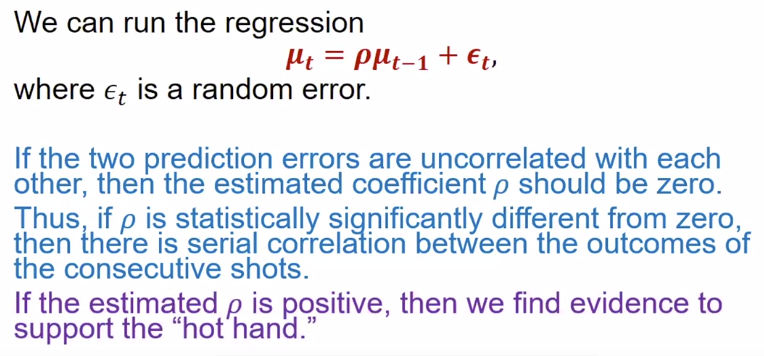

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import statsmodels.formula.api as sm

### Create a variable for Prediction Error

* Prediction error is nothing but the difference between the outcome of the shot, and the average success rate.

In [39]:
shotlog["error"] = shotlog["current_shot_hit"] - shotlog["average_hit"]
shotlog["lagerror"] = shotlog["lag_shot_hit"] - shotlog["average_hit"]

In [40]:
shotlog["time"] = pd.to_timedelta(shotlog["time"])
shotlog["time"].describe()

count                       185052
mean     0 days 00:06:41.184494088
std      0 days 00:03:13.352599232
min                0 days 00:00:10
25%                0 days 00:03:59
50%                0 days 00:06:43
75%                0 days 00:09:28
max                0 days 00:12:00
Name: time, dtype: object

**In python, scatterplot requires the x-axis to be numeric! It does not allows x-axis to be a date or a time variable. To overcome this --> create a line graph, and specify the width of the line = 0**

<AxesSubplot:xlabel='time'>

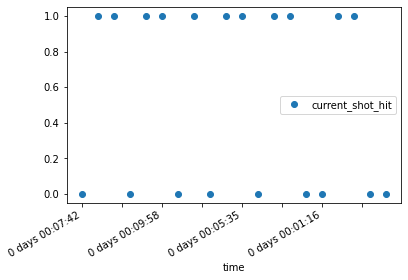

In [41]:
"""Visualize data: Graph the outcome of the shot for a player in a certain game"""
shotlog[(shotlog.shoot_player == "LeBron James") & (shotlog.date == "2017-04-09")].plot(x="time", y = "current_shot_hit", marker = "o", linewidth = 0)

In [42]:
"""Visualize a graph of shot outcomes for LeBron James throughout the Regular Season"""
LeBron_James = shotlog[(shotlog.shoot_player == "LeBron James")]
LeBron_James.head()

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,...,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit,average_hit,shot_count,shot_per_game,conse_shot_hit,error,lagerror
38800,MISSED,SF,Yes,236.0,MISSED,CLE,Jump Shot,3,NYK,84.0,...,1,MISSED,0,0.0,0.547619,1344,14,0,-0.547619,-0.547619
38801,BLOCKED,SF,Yes,264.0,SCORED,CLE,Jump Shot,3,NYK,383.0,...,1,MISSED,0,1.0,0.547619,1344,14,0,-0.547619,0.452381
38802,SCORED,SF,Yes,50.0,MISSED,CLE,Running Layup,2,NYK,259.0,...,1,SCORED,1,1.0,0.547619,1344,14,1,0.452381,0.452381
38803,MISSED,SF,Yes,52.0,SCORED,CLE,Putback Dunk,2,NYK,250.0,...,1,SCORED,1,1.0,0.547619,1344,14,1,0.452381,0.452381
38804,MISSED,SF,Yes,52.0,MISSED,CLE,Dunk,2,NYK,250.0,...,2,SCORED,1,1.0,0.547619,1344,14,1,0.452381,0.452381


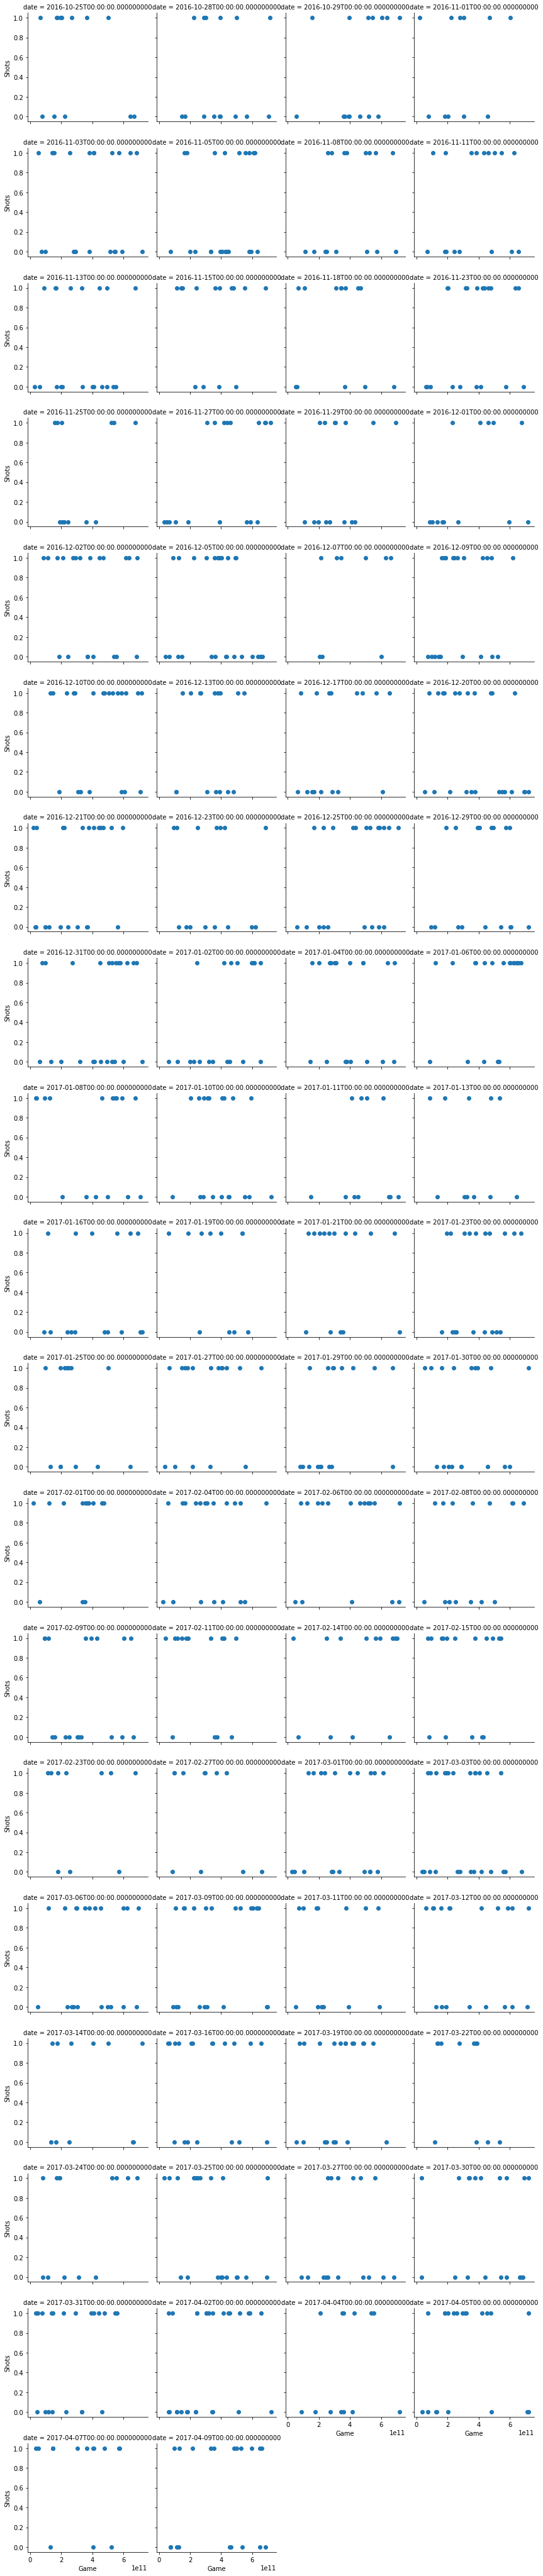

In [43]:
g = sns.FacetGrid(LeBron_James, col = "date", col_wrap = 4)
g = g.map(plt.plot, "time", "current_shot_hit", marker = "o", linewidth = 0)
g.set_axis_labels("Game", "Shots");

### I. Regression Analysis on Prediction Error

* Regression analysis on prediction error of current period, on the prediction error of previous period

In [44]:
reg1 = sm.ols(formula = "error ~ lagerror", data = shotlog).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     27.53
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           1.55e-07
Time:                        22:15:08   Log-Likelihood:            -1.3244e+05
No. Observations:              185052   AIC:                         2.649e+05
Df Residuals:                  185050   BIC:                         2.649e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0009      0.001      0.818      0.4

* **Result:**
    * lag error is statistically significant, BUT R-squared value = 0 --> **Our specified linear model is not a good fit for out data at all!**

### II. Regression on Predicton Error with other External Factors

In [45]:
reg2 = sm.ols(formula = "error ~ lagerror + player_position + home_game + opponent_previous_shot + C(points) + time_from_last_shot + C(quarter)", data = shotlog).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     139.0
Date:                Wed, 24 Nov 2021   Prob (F-statistic):               0.00
Time:                        22:15:13   Log-Likelihood:            -1.2968e+05
No. Observations:              183014   AIC:                         2.594e+05
Df Residuals:                  182994   BIC:                         2.596e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

* **Result:**
    * R - squared value has increased, but is still very small (1.4%)
    * lagerror is statistically significant, but the magnitude is negative and extremely small

### Weighted Least Squares Regression:
* Currently, the total number of shots taken by each player, vary drastically. Different players may have different success rates in shots --> **Run a weighted least squares regression to address this**
    * Weighted Least Squares Regression: Weights the observations proportional to the reciprocal of the error variance of the observation. **Weighted Least Squares, overcomes the issue of non-constant variance**

In [46]:
reg3 = sm.wls(formula = "error ~ lagerror + player_position + home_game + opponent_previous_shot + points + time_from_last_shot + quarter", weights = 1/shotlog["shot_per_game"], data = shotlog).fit()
print(reg3.summary())

                            WLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.015
Model:                            WLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     145.5
Date:                Wed, 24 Nov 2021   Prob (F-statistic):               0.00
Time:                        22:15:18   Log-Likelihood:            -1.4283e+05
No. Observations:              183014   AIC:                         2.857e+05
Df Residuals:                  182994   BIC:                         2.859e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

* **Result:**
    * R-squared increased, but is still very small
    * lagerror is still negative and the maginitude is very small

### III. Regression for Individual Players

In [47]:
reg_LeBron = sm.ols(formula = "error ~ lagerror + home_game + opponent_previous_shot + C(points) + time_from_last_shot + C(quarter)", data = LeBron_James).fit()
print(reg_LeBron.summary())

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     6.204
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           5.23e-10
Time:                        22:15:19   Log-Likelihood:                -867.52
No. Observations:                1250   AIC:                             1759.
Df Residuals:                    1238   BIC:                             1821.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

* **Result:**
    * R-squared value increased to 5.2%
    * lagerror is not statistically significant

In [48]:
reg_LeBron_wls = sm.ols(formula = "error ~ lagerror + home_game + opponent_previous_shot + points + time_from_last_shot + quarter", weight = 1/LeBron_James['shot_per_game'], data = LeBron_James).fit()
print(reg_LeBron_wls.summary())

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     6.204
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           5.23e-10
Time:                        22:15:19   Log-Likelihood:                -867.52
No. Observations:                1250   AIC:                             1759.
Df Residuals:                    1238   BIC:                             1821.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

* **Result:**
    * R-squared value increased to 5.2%
    * lagerror is not statistically significant

### Automated Function to test regression of players

In [49]:
def reg_player(player):
    shotlog_player=shotlog[shotlog.shoot_player==player]
    reg_player=sm.ols(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', data= shotlog_player).fit()
    print(reg_player.summary())
    return; 

In [50]:
reg_player("Russell Westbrook")

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.028
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           0.000824
Time:                        22:15:19   Log-Likelihood:                -1307.5
No. Observations:                1854   AIC:                             2637.
Df Residuals:                    1843   BIC:                             2698.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [51]:
def reg_wls_player(player):
    shotlog_player=shotlog[shotlog.shoot_player==player]
    reg_wls_player=sm.wls(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter',weights=1/shotlog_player['shot_per_game'] , data= shotlog_player).fit()
    print(reg_wls_player.summary())
    return; 

In [52]:
reg_wls_player('Russell Westbrook')

                            WLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.017
Model:                            WLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.260
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           0.000345
Time:                        22:15:19   Log-Likelihood:                -1342.7
No. Observations:                1854   AIC:                             2707.
Df Residuals:                    1843   BIC:                             2768.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

### Run regression for all players

In [53]:
# Create a list for all unique players
player_list = np.array(shotlog["shoot_player"])
player_list = np.unique(player_list)

In [54]:
player_list[0]

'A.J. Hammons'

In [55]:
shotlog_player=shotlog[shotlog.shoot_player==player_list[0]]
reg_player=sm.wls(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', weights=1/shotlog_player['shot_per_game'], data= shotlog_player).fit()
print(reg_player.summary())

                            WLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.439
Model:                            WLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     2.122
Date:                Wed, 24 Nov 2021   Prob (F-statistic):             0.0912
Time:                        22:15:20   Log-Likelihood:                -11.924
No. Observations:                  27   AIC:                             39.85
Df Residuals:                      19   BIC:                             50.21
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

* **Extract the estimated coefficients, along with the p-value and t-statistics of the estimates and store them in a dataframe**

In [56]:
RegParams = pd.DataFrame(reg_player.params).reset_index()
RegTvals = pd.DataFrame(reg_player.tvalues).reset_index()
RegPvals = pd.DataFrame(reg_player.pvalues).reset_index()

RegOutput = pd.merge(RegParams, RegTvals, on=['index'])
RegOutput = pd.merge(RegOutput, RegPvals, on=['index'])
RegOutput

,index,0_x,0_y,0
0,Intercept,0.186664,0.476881,0.638886
1,home_game[T.Yes],-0.249695,-1.182271,0.251683
2,opponent_previous_shot[T.SCORED],-0.539579,-2.188470,0.041330
3,points[T.3],-0.151942,-0.616550,0.544849
4,quarter[T.3],0.197924,0.532032,0.600871
5,quarter[T.4],0.444779,1.331474,0.198788
6,lagerror,0.150228,0.663457,0.515008
7,time_from_last_shot,-0.003807,-0.528474,0.603290


- Write a loop to extract regression outputs for each player

In [57]:
i = 0 
Player_Results = {}
while i <= len(player_list) - 1:
    shotlog_player=shotlog[shotlog.shoot_player==player_list[i]]
    reg_player=sm.wls(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', weights=1/shotlog_player['shot_per_game'], data= shotlog_player).fit()
    RegParams = pd.DataFrame(reg_player.params).reset_index()
    RegTvals = pd.DataFrame(reg_player.tvalues).reset_index()
    RegPvals = pd.DataFrame(reg_player.pvalues).reset_index()

    RegOutput = pd.merge(RegParams, RegTvals, on=['index'])
    RegOutput = pd.merge(RegOutput, RegPvals, on=['index'])
    RegOutput
    
    LagErr = RegOutput[RegOutput['index'] == 'lagerror']
    LagErr = LagErr.drop(columns=['index'])
    LagErr = LagErr.rename(columns={"0_x":"Coef", "0_y":"T_Statistics", 0:"P_Value"})
    LagErr['shoot_player'] = player_list[i]
    Headers = ['shoot_player', 'Coef', 'T_Statistics', 'P_Value']
    Player_Results[i] = LagErr[Headers]
    i = i+1

- Write another loop to build a dataframe to store the regression output for all the players

In [58]:
RegPlayer = Player_Results[0]
j = 1
while j <= len(player_list) - 1:
    RegPlayer = RegPlayer.append(Player_Results[j])
    j = j+1
RegPlayer = RegPlayer.reset_index()
RegPlayer = RegPlayer.drop(columns=['index'])
RegPlayer

,shoot_player,Coef,T_Statistics,P_Value
0,A.J. Hammons,0.150228,0.663457,0.515008
1,Aaron Brooks,0.016119,0.234061,0.815147
2,Aaron Gordon,0.023249,0.665640,0.505841
3,Adreian Payne,-0.221437,-1.318109,0.197784
4,Al Horford,-0.028877,-0.787581,0.431204
...,...,...,...,...
476,Wilson Chandler,-0.050306,-1.490297,0.136516
477,Yogi Ferrell,-0.139387,-2.627093,0.009008
478,Zach LaVine,-0.099240,-2.560393,0.010683
479,Zach Randolph,0.025095,0.742049,0.458259


* Merge the total number of shots captured in "Player_Shots" to the regression result dataframe. This total number of shots represents the sample size of each regression

In [59]:
RegPlayer=pd.merge(RegPlayer, player_shots, on=['shoot_player'])
RegPlayer.head()

,shoot_player,Coef,T_Statistics,P_Value,shot_count,avg_shot_game
0,A.J. Hammons,0.150228,0.663457,0.515008,42,2.800000
1,Aaron Brooks,0.016119,0.234061,0.815147,300,4.838710
2,Aaron Gordon,0.023249,0.665640,0.505841,864,10.800000
3,Adreian Payne,-0.221437,-1.318109,0.197784,54,3.600000
4,Al Horford,-0.028877,-0.787581,0.431204,801,11.779412


In [60]:
display(RegPlayer.loc[RegPlayer['P_Value']<=0.05])

,shoot_player,Coef,T_Statistics,P_Value,shot_count,avg_shot_game
5,Al Jefferson,-0.135492,-2.688399e+00,7.488125e-03,471,7.246154
35,Avery Bradley,-0.080427,-2.143972e+00,3.237994e-02,775,14.090909
46,Boris Diaw,0.153381,2.521241e+00,1.232973e-02,327,4.671429
76,Christian Wood,-0.693104,-4.015807e+00,1.016289e-02,23,2.555556
79,Cole Aldrich,-0.497363,-2.748164e+00,9.639093e-03,86,1.954545
94,Dario Saric,-0.070551,-2.071264e+00,3.864452e-02,927,11.444444
96,Darren Collison,0.103515,2.647946e+00,8.301971e-03,713,10.485294
137,Elijah Millsap,-0.080537,-2.984931e+13,2.132779e-14,7,3.500000
190,Jameer Nelson,-0.095271,-2.178297e+00,2.983677e-02,604,8.053333
195,James Michael McAdoo,0.311074,2.715049e+00,8.448460e-03,118,2.809524


There are a total of 38 players with statistically significant estimates on the lagged error variable, that is, the success of their previous shots impact the success rate of their current shot. Interestingly, more than half of these estimates are negative, which means that a success in the previous shot actually hurts the chance of scoring in the current shot. This is the opposite of a "hot hand."

Overall from our regression analyses, 8 players, Boris Diaw, Brandon Rush, Frank Kaminsky, Joe Young, Jose Calderon, Kyle Wiltjer, Omri Casspi, Robert Covington, and Tony Parker have positive and statistically significant estimate on the lagged error variable. Thus, these players may have "hot hand." Note that the estimate for Kyle Wiltjer is 1 and there are only a total of 14 observations for him. We need to interpret his result with caution.